# 🌡️ Case Study: Temperature Prediction with LWLR

---

## Why Local Matters in Weather Prediction

Weather is inherently **non-linear**. The relationship between time-of-day and temperature isn't constant—it changes throughout the day, across seasons, and with countless environmental factors.

> **The Challenge**: Predict temperature from time-of-day, accounting for LOCAL patterns that a single global line can't capture.

This is where **Locally Weighted Linear Regression (LWLR)** absolutely shines!

---

### 🔑 The Key Insight

**Standard Linear Regression**: Fits ONE global line through ALL data points.  
**LWLR**: Fits a LOCAL line for EACH prediction point, weighted by distance.

**Analogy**: It's like asking only your **neighbors** for directions, not the entire city!

When you're at hour 14 (2 PM), the data points around 2 PM are FAR more relevant than midnight data. LWLR formalizes this intuition mathematically.

---

### What We'll Cover

| Section | Topic |
|---------|-------|
| 1 | Load realistic daily temperature data |
| 2 | Visualize WHY linear regression fails |
| 3 | Build LWLR from scratch |
| 4 | Compare Linear vs LWLR (side-by-side) |
| 5 | Explore the bandwidth parameter τ |
| 6 | Cross-validation for optimal τ |
| 7 | Real-world insights and when to use LWLR |

Let's dive in! 🚀

## 📊 Part 1: Creating Realistic Temperature Data

Real weather follows predictable patterns with natural variation:
- **Daily cycle**: Coldest around 5-6 AM, warmest around 2-3 PM
- **Sinusoidal pattern**: Temperature rises and falls smoothly
- **Noise**: Weather isn't perfectly predictable—clouds, wind, humidity add variation

We'll simulate **Delhi-like weather** patterns:
- Summer base: ~30°C
- Daily amplitude: ~10°C (swing from low to high)
- Random noise: ~2°C standard deviation

This mimics real meteorological data but gives us full control for learning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# ============================================================
# CREATE REALISTIC DAILY TEMPERATURE PATTERN
# ============================================================
# Simulate 7 days of hourly temperature readings (168 data points)
n_days = 7
hours_per_day = 24
n_samples = n_days * hours_per_day

# Hour of day (0-24 repeated for each day)
hours = np.tile(np.linspace(0, 24, hours_per_day), n_days)
day_number = np.repeat(np.arange(n_days), hours_per_day)

# Base temperature (Delhi summer-like)
base_temp = 30  # Celsius

# Daily amplitude (how much temp swings from low to high)
daily_amplitude = 10  # degrees

# The sinusoidal pattern:
# - Minimum at hour ~6 (early morning)
# - Maximum at hour ~14 (afternoon)
# Formula: base + amplitude * sin((hour - 6) * π / 12)
# This shifts the sine wave so minimum is at hour 6, max at hour 18

true_temp = base_temp + daily_amplitude * np.sin((hours - 6) * np.pi / 12)

# Add realistic noise (weather isn't perfect)
noise = np.random.normal(0, 2, n_samples)

# Also add slight day-to-day variation
day_variation = np.random.normal(0, 1.5, n_days)
day_offset = np.repeat(day_variation, hours_per_day)

# Final observed temperature
observed_temp = true_temp + noise + day_offset

# Create humidity (inversely related to temp, roughly)
# High humidity in morning, low in afternoon
base_humidity = 65
humidity = base_humidity - 15 * np.sin((hours - 6) * np.pi / 12) + np.random.normal(0, 5, n_samples)
humidity = np.clip(humidity, 30, 95)  # Physical bounds

# Create DataFrame
df = pd.DataFrame({
    'day': day_number + 1,
    'hour': hours,
    'humidity': humidity,
    'temperature': observed_temp,
    'true_temp': true_temp  # Keep for comparison
})

# Display summary
print("🌡️ Daily Temperature Pattern (Delhi-like Summer Weather)")
print("=" * 55)
print(f"   📅 Days of data:        {n_days}")
print(f"   📍 Total samples:       {len(df)}")
print(f"   🌡️  Temperature range:   {observed_temp.min():.1f}°C to {observed_temp.max():.1f}°C")
print(f"   💧 Humidity range:      {humidity.min():.1f}% to {humidity.max():.1f}%")
print(f"   📊 Mean temperature:    {observed_temp.mean():.1f}°C")
print()
print("📋 First 10 rows:")
print(df.head(10).to_string(index=False))

🌡️ Daily Temperature Pattern (Delhi-like Summer Weather)
   📅 Days of data:        7
   📍 Total samples:       168
   🌡️  Temperature range:   15.0°C to 44.1°C
   💧 Humidity range:      40.1% to 89.4%
   📊 Mean temperature:    29.0°C

📋 First 10 rows:
 day     hour  humidity  temperature  true_temp
   1 0.000000 84.135916    20.625346  20.000000
   1 1.043478 79.508769    19.726216  20.370827
   1 2.086957 85.083961    22.383101  21.455806
   1 3.130435 73.915013    25.852446  23.174469
   1 4.173913 85.501821    24.562961  25.399350
   1 5.217391 71.180177    27.129084  27.965440
   1 6.260870 59.690576    33.472768  30.682424
   1 7.304348 54.622343    34.515583  33.348796
   1 8.347826 58.762157    34.459772  35.766803
   1 9.391304 52.247017    38.474151  37.757113


## 📈 Part 2: Visualize the Non-Linearity

Let's SEE why standard linear regression will fail.

The temperature pattern is clearly **sinusoidal**—a straight line simply cannot capture this shape. This is the EXACT scenario where LWLR excels.

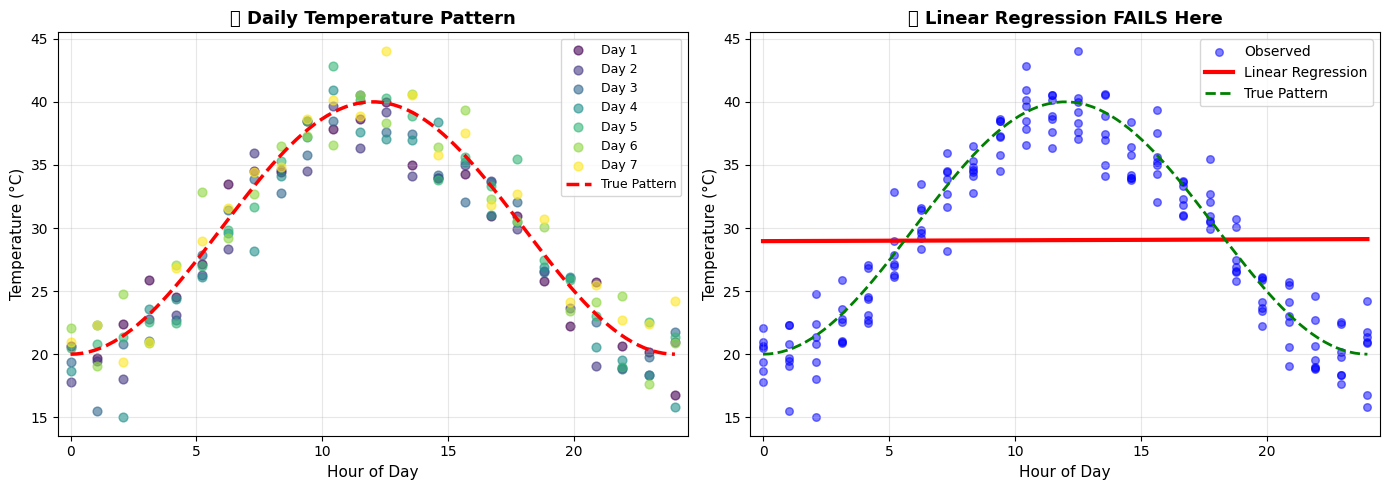

❌ Linear Regression Performance:
   RMSE:  7.35°C  (average error)
   R²:    0.0000   (expothers almost nothing!)

💡 Insight: The straight line is essentially useless here.
   It predicts ~30°C for everything, ignoring the daily cycle completely!


In [2]:
# ============================================================
# VISUALIZE: THE NON-LINEAR NATURE OF TEMPERATURE DATA
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scatter plot of all data
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, n_days))
for day in range(n_days):
    mask = df['day'] == day + 1
    ax1.scatter(df.loc[mask, 'hour'], df.loc[mask, 'temperature'], 
                alpha=0.6, c=[colors[day]], label=f'Day {day+1}', s=40)

# Overlay the true pattern
hours_smooth = np.linspace(0, 24, 100)
true_pattern = base_temp + daily_amplitude * np.sin((hours_smooth - 6) * np.pi / 12)
ax1.plot(hours_smooth, true_pattern, 'r--', linewidth=2.5, label='True Pattern')

ax1.set_xlabel('Hour of Day', fontsize=11)
ax1.set_ylabel('Temperature (°C)', fontsize=11)
ax1.set_title('🌡️ Daily Temperature Pattern', fontsize=13, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-0.5, 24.5)

# Plot 2: What Linear Regression would do
ax2 = axes[1]
X_simple = df['hour'].values.reshape(-1, 1)
y_simple = df['temperature'].values

# Fit linear regression
lr_model = LinearRegression()
lr_model.fit(X_simple, y_simple)
y_pred_lr = lr_model.predict(X_simple)

ax2.scatter(df['hour'], df['temperature'], alpha=0.5, c='blue', s=30, label='Observed')
ax2.plot(df['hour'].sort_values(), lr_model.predict(df['hour'].sort_values().values.reshape(-1,1)), 
         'r-', linewidth=3, label=f'Linear Regression')
ax2.plot(hours_smooth, true_pattern, 'g--', linewidth=2, label='True Pattern')

ax2.set_xlabel('Hour of Day', fontsize=11)
ax2.set_ylabel('Temperature (°C)', fontsize=11)
ax2.set_title('❌ Linear Regression FAILS Here', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-0.5, 24.5)

plt.tight_layout()
plt.show()

# Calculate Linear Regression error
lr_mse = mean_squared_error(y_simple, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_simple, y_pred_lr)

print("❌ Linear Regression Performance:")
print(f"   RMSE:  {lr_rmse:.2f}°C  (average error)")
print(f"   R²:    {lr_r2:.4f}   (expothers almost nothing!)")
print()
print("💡 Insight: The straight line is essentially useless here.")
print("   It predicts ~30°C for everything, ignoring the daily cycle completely!")

## 🧠 Part 3: LWLR from Scratch

### The Core Intuition

For each query point $x_q$, LWLR:

1. **Assigns weights** to training points based on distance from $x_q$
2. **Fits weighted least squares** using those weights
3. **Returns prediction** for just that one point

The weight function is a **Gaussian kernel**:

$$w_i = \exp\left(-\frac{(x_i - x_q)^2}{2\tau^2}\right)$$

Where:
- $w_i$ = weight for training point $i$
- $x_i$ = training point feature
- $x_q$ = query point (where we want to predict)
- $\tau$ = **bandwidth** (controls how "local" we are)

### The Weighted Least Squares Solution

$$\theta = (X^T W X)^{-1} X^T W y$$

This is just like normal equations, but with weight matrix $W = \text{diag}(w_1, w_2, ..., w_n)$

**Small τ** → Only very close neighbors matter → More wiggly fit  
**Large τ** → Far points also matter → Smoother fit (approaches global regression)

In [3]:
# ============================================================
# LWLR IMPLEMENTATION FROM SCRATCH
# ============================================================

class LWLR:
    """
    Locally Weighted Linear Regression
    
    Instead of fitting ONE global model, LWLR fits a LOCAL model
    for each prediction point, giving more weight to nearby training points.
    
    Parameters
    ----------
    tau : float
        Bandwidth parameter. Controls how "local" the fit is.
        - Small tau (e.g., 0.5): Very local, only close neighbors matter
        - Large tau (e.g., 5.0): Less local, many points contribute
    """
    
    def __init__(self, tau=1.0):
        self.tau = tau
    
    def _gaussian_weight(self, x_query, X_train):
        """
        Compute Gaussian weights based on distance from query point.
        
        Points close to x_query get weight ≈ 1
        Points far from x_query get weight ≈ 0
        """
        # Squared Euclidean distance
        diff = X_train - x_query
        sq_dist = np.sum(diff ** 2, axis=1) if diff.ndim > 1 else diff ** 2
        
        # Gaussian kernel: exp(-d² / 2τ²)
        weights = np.exp(-sq_dist / (2 * self.tau ** 2))
        return weights
    
    def predict_single(self, x_query, X_train, y_train):
        """
        Predict for a SINGLE query point.
        
        This is the heart of LWLR—we solve weighted least squares
        specifically for this one point.
        """
        # Step 1: Compute weights (nearby points get higher weight)
        weights = self._gaussian_weight(x_query, X_train)
        W = np.diag(weights)
        
        # Step 2: Add bias term (column of 1s)
        X_b = np.c_[np.ones(len(X_train)), X_train]
        x_query_b = np.r_[1, x_query] if hasattr(x_query, '__len__') else np.array([1, x_query])
        
        # Step 3: Weighted least squares solution
        # θ = (X'WX)⁻¹ X'Wy
        # We use pinv for numerical stability
        XWX = X_b.T @ W @ X_b
        XWy = X_b.T @ W @ y_train
        
        # Add tiny regularization for numerical stability
        XWX += 1e-8 * np.eye(XWX.shape[0])
        
        theta = np.linalg.solve(XWX, XWy)
        
        # Step 4: Predict
        return x_query_b @ theta
    
    def predict(self, X_query, X_train, y_train):
        """
        Predict for MULTIPLE query points.
        
        Note: This is O(n²) - we refit the model for EACH query point!
        That's the trade-off of LWLR: flexibility for computational cost.
        """
        X_query = np.atleast_1d(X_query)
        if X_query.ndim == 1:
            X_query = X_query.reshape(-1, 1)
            X_train_use = X_train.reshape(-1, 1) if X_train.ndim == 1 else X_train
        else:
            X_train_use = X_train
        
        predictions = []
        for x_q in X_query:
            pred = self.predict_single(x_q, X_train_use, y_train)
            predictions.append(pred)
        
        return np.array(predictions)
    
    def __repr__(self):
        return f"LWLR(tau={self.tau})"


# Quick test
print("✅ LWLR class defined successfully!")
print()
print("Key methods:")
print("  • predict_single(x_query, X_train, y_train) → one prediction")
print("  • predict(X_query, X_train, y_train) → batch predictions")
print()
print("🔧 Bandwidth parameter tau controls locality:")
print("   Small τ → Very local (wiggly)")
print("   Large τ → More global (smooth)")

✅ LWLR class defined successfully!

Key methods:
  • predict_single(x_query, X_train, y_train) → one prediction
  • predict(X_query, X_train, y_train) → batch predictions

🔧 Bandwidth parameter tau controls locality:
   Small τ → Very local (wiggly)
   Large τ → More global (smooth)


## ⚔️ Part 4: Linear Regression vs LWLR — Head to Head

Now the moment of truth! Let's compare:
1. **Standard Linear Regression**: One line for all data
2. **LWLR**: Local lines for each prediction point

We'll use the same train/test split for a fair comparison.

In [4]:
# ============================================================
# HEAD-TO-HEAD: LINEAR REGRESSION VS LWLR
# ============================================================

# Prepare data
X = df['hour'].values
y = df['temperature'].values

# Train-test split (use 70% for training)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"📊 Data Split:")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples:     {len(X_test)}")
print()

# ---- Model 1: Standard Linear Regression ----
lr = LinearRegression()
lr.fit(X_train.reshape(-1, 1), y_train)
y_pred_lr = lr.predict(X_test.reshape(-1, 1))

# ---- Model 2: LWLR (with tau=1.5) ----
lwlr = LWLR(tau=1.5)
y_pred_lwlr = lwlr.predict(X_test, X_train, y_train)

# ---- Calculate Metrics ----
def calc_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'Model': name, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

metrics_lr = calc_metrics(y_test, y_pred_lr, 'Linear Regression')
metrics_lwlr = calc_metrics(y_test, y_pred_lwlr, 'LWLR (τ=1.5)')

# Display comparison
print("=" * 60)
print("📊 MODEL COMPARISON")
print("=" * 60)
metrics_df = pd.DataFrame([metrics_lr, metrics_lwlr])
metrics_df = metrics_df.set_index('Model')
print(metrics_df.to_string())
print()

# Calculate improvement
rmse_improvement = (metrics_lr['RMSE'] - metrics_lwlr['RMSE']) / metrics_lr['RMSE'] * 100
r2_improvement = metrics_lwlr['R²'] - metrics_lr['R²']

print("🚀 LWLR Improvement:")
print(f"   RMSE reduced by: {rmse_improvement:.1f}%")
print(f"   R² increased by: {r2_improvement:.3f}")

📊 Data Split:
   Training samples: 117
   Test samples:     51

📊 MODEL COMPARISON
                       RMSE       MAE        R²
Model                                          
Linear Regression  7.622919  6.723592 -0.004180
LWLR (τ=1.5)       2.224029  1.810469  0.914523

🚀 LWLR Improvement:
   RMSE reduced by: 70.8%
   R² increased by: 0.919


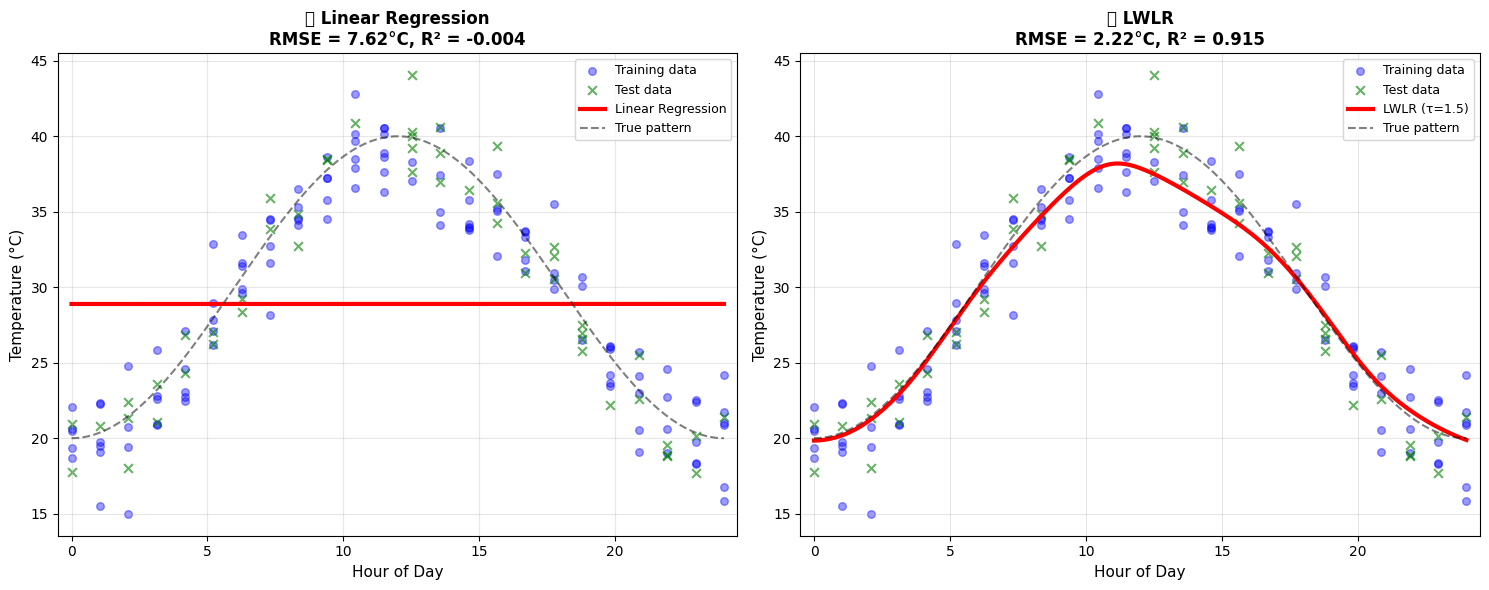

🎯 Visual Analysis:
   • Linear Regression: Completely misses the curve!
   • LWLR: Beautifully captures the sinusoidal temperature pattern

💡 The red LWLR curve follows the black dashed true pattern closely.


In [5]:
# ============================================================
# VISUALIZE THE PREDICTIONS
# ============================================================

# Create smooth predictions for visualization
X_smooth = np.linspace(0, 24, 200)
y_smooth_lr = lr.predict(X_smooth.reshape(-1, 1))
y_smooth_lwlr = lwlr.predict(X_smooth, X_train, y_train)

# True pattern for reference
y_true_pattern = base_temp + daily_amplitude * np.sin((X_smooth - 6) * np.pi / 12)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ---- Plot 1: Linear Regression ----
ax1 = axes[0]
ax1.scatter(X_train, y_train, alpha=0.4, c='blue', s=30, label='Training data')
ax1.scatter(X_test, y_test, alpha=0.6, c='green', s=40, marker='x', label='Test data')
ax1.plot(X_smooth, y_smooth_lr, 'r-', linewidth=3, label='Linear Regression')
ax1.plot(X_smooth, y_true_pattern, 'k--', linewidth=1.5, alpha=0.5, label='True pattern')

ax1.set_xlabel('Hour of Day', fontsize=11)
ax1.set_ylabel('Temperature (°C)', fontsize=11)
ax1.set_title(f'❌ Linear Regression\nRMSE = {metrics_lr["RMSE"]:.2f}°C, R² = {metrics_lr["R²"]:.3f}', 
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-0.5, 24.5)

# ---- Plot 2: LWLR ----
ax2 = axes[1]
ax2.scatter(X_train, y_train, alpha=0.4, c='blue', s=30, label='Training data')
ax2.scatter(X_test, y_test, alpha=0.6, c='green', s=40, marker='x', label='Test data')
ax2.plot(X_smooth, y_smooth_lwlr, 'r-', linewidth=3, label='LWLR (τ=1.5)')
ax2.plot(X_smooth, y_true_pattern, 'k--', linewidth=1.5, alpha=0.5, label='True pattern')

ax2.set_xlabel('Hour of Day', fontsize=11)
ax2.set_ylabel('Temperature (°C)', fontsize=11)
ax2.set_title(f'✅ LWLR\nRMSE = {metrics_lwlr["RMSE"]:.2f}°C, R² = {metrics_lwlr["R²"]:.3f}', 
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-0.5, 24.5)

plt.tight_layout()
plt.show()

print("🎯 Visual Analysis:")
print("   • Linear Regression: Completely misses the curve!")
print("   • LWLR: Beautifully captures the sinusoidal temperature pattern")
print()
print("💡 The red LWLR curve follows the black dashed true pattern closely.")

## 🎛️ Part 5: The Bandwidth Parameter τ (Tau)

The bandwidth τ is the **single most important hyperparameter** in LWLR.

| τ Value | Effect | Risk |
|---------|--------|------|
| **Small** (0.3-0.5) | Very local, wiggly | Overfitting |
| **Medium** (1.0-2.0) | Balanced | Usually best |
| **Large** (5.0+) | Almost global | Underfitting |

Let's visualize how different τ values affect the fit:

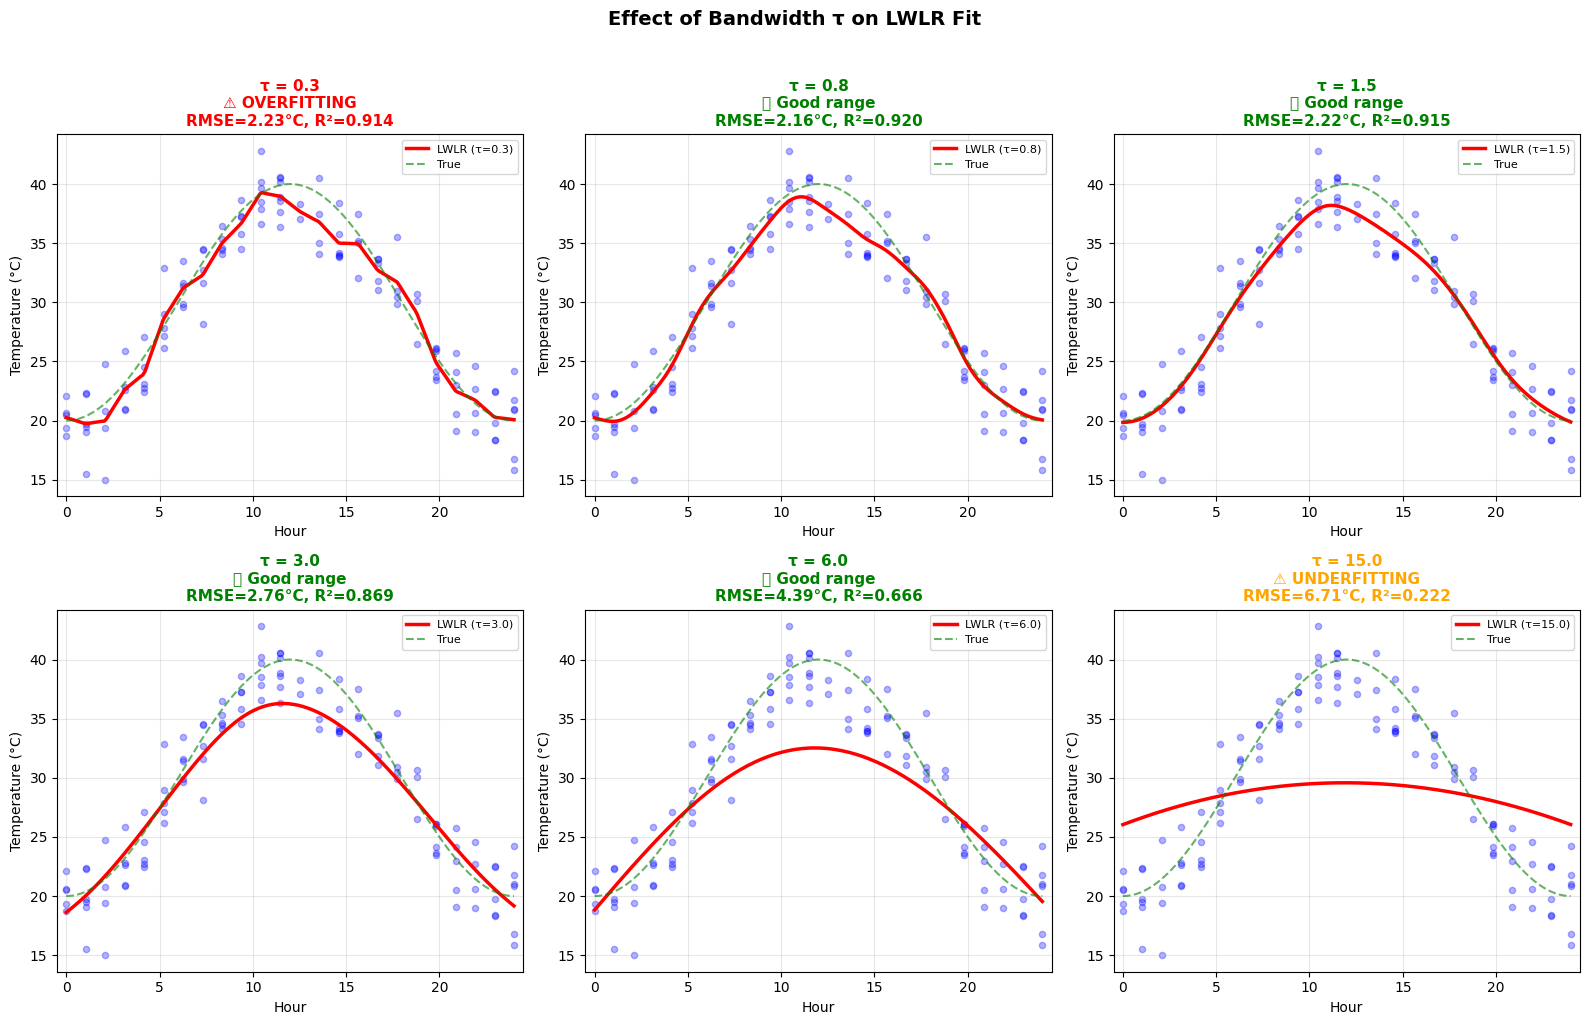

📊 Analysis of τ values:

   τ = 0.3:  Very wiggly - responds to every little bump in data (OVERFIT)
   τ = 0.8:  Still somewhat wiggly but captures pattern
   τ = 1.5:  Nice balance - smooth yet flexible
   τ = 3.0:  Slightly smoother, still good
   τ = 6.0:  Getting too smooth, losing detail
   τ = 15.0: Almost a straight line again (UNDERFIT)

💡 Key Insight: As τ → ∞, LWLR approaches global linear regression!


In [6]:
# ============================================================
# EXPLORING THE BANDWIDTH PARAMETER τ
# ============================================================

# Test different tau values
tau_values = [0.3, 0.8, 1.5, 3.0, 6.0, 15.0]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

X_smooth = np.linspace(0, 24, 200)
y_true_pattern = base_temp + daily_amplitude * np.sin((X_smooth - 6) * np.pi / 12)

for idx, tau in enumerate(tau_values):
    ax = axes[idx]
    
    # Fit LWLR with this tau
    model = LWLR(tau=tau)
    y_pred = model.predict(X_smooth, X_train, y_train)
    
    # Calculate test error
    y_test_pred = model.predict(X_test, X_train, y_train)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Plot
    ax.scatter(X_train, y_train, alpha=0.3, c='blue', s=20)
    ax.plot(X_smooth, y_pred, 'r-', linewidth=2.5, label=f'LWLR (τ={tau})')
    ax.plot(X_smooth, y_true_pattern, 'g--', linewidth=1.5, alpha=0.6, label='True')
    
    # Determine status
    if tau < 0.5:
        status = "⚠️ OVERFITTING"
        color = 'red'
    elif tau > 8:
        status = "⚠️ UNDERFITTING"
        color = 'orange'
    else:
        status = "✅ Good range"
        color = 'green'
    
    ax.set_title(f'τ = {tau}\n{status}\nRMSE={test_rmse:.2f}°C, R²={test_r2:.3f}', 
                 fontsize=11, fontweight='bold', color=color)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Temperature (°C)')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.5, 24.5)

plt.suptitle('Effect of Bandwidth τ on LWLR Fit', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("📊 Analysis of τ values:")
print()
print("   τ = 0.3:  Very wiggly - responds to every little bump in data (OVERFIT)")
print("   τ = 0.8:  Still somewhat wiggly but captures pattern")
print("   τ = 1.5:  Nice balance - smooth yet flexible")
print("   τ = 3.0:  Slightly smoother, still good")
print("   τ = 6.0:  Getting too smooth, losing detail")
print("   τ = 15.0: Almost a straight line again (UNDERFIT)")
print()
print("💡 Key Insight: As τ → ∞, LWLR approaches global linear regression!")

## 🔍 Part 6: Cross-Validation for Optimal τ

How do we find the BEST τ? **Cross-validation!**

We'll:
1. Try a range of τ values
2. For each τ, compute K-fold cross-validation RMSE
3. Pick the τ with lowest CV error

This is crucial because:
- **Training error** always decreases with smaller τ (overfitting)
- **Test/CV error** shows the true generalization performance

In [7]:
# ============================================================
# CROSS-VALIDATION TO FIND OPTIMAL τ
# ============================================================

def cross_validate_lwlr(X, y, tau_values, n_folds=5):
    """
    Perform K-fold cross-validation for LWLR across different tau values.
    Returns mean and std of RMSE for each tau.
    """
    results = []
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for tau in tau_values:
        fold_rmses = []
        
        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]
            
            # Fit and predict
            model = LWLR(tau=tau)
            y_pred = model.predict(X_val, X_tr, y_tr)
            
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            fold_rmses.append(rmse)
        
        results.append({
            'tau': tau,
            'mean_rmse': np.mean(fold_rmses),
            'std_rmse': np.std(fold_rmses)
        })
    
    return pd.DataFrame(results)

# Test a range of tau values
tau_range = np.linspace(0.3, 5.0, 20)

print("🔄 Running 5-fold cross-validation for 20 τ values...")
print("   (This may take a moment - LWLR is O(n²) per prediction)")
print()

cv_results = cross_validate_lwlr(X_train, y_train, tau_range, n_folds=5)

# Find optimal tau
best_idx = cv_results['mean_rmse'].idxmin()
best_tau = cv_results.loc[best_idx, 'tau']
best_rmse = cv_results.loc[best_idx, 'mean_rmse']

print("📊 Cross-Validation Results:")
print(cv_results.to_string(index=False))
print()
print(f"🏆 OPTIMAL τ = {best_tau:.2f}")
print(f"   CV RMSE = {best_rmse:.3f}°C")

🔄 Running 5-fold cross-validation for 20 τ values...
   (This may take a moment - LWLR is O(n²) per prediction)

📊 Cross-Validation Results:
     tau  mean_rmse  std_rmse
0.300000   2.419782  0.304291
0.547368   2.294320  0.355910
0.794737   2.234241  0.386291
1.042105   2.220123  0.409130
1.289474   2.226471  0.431647
1.536842   2.248416  0.452414
1.784211   2.281446  0.469215
2.031579   2.323114  0.480869
2.278947   2.373820  0.487376
2.526316   2.435177  0.489464
2.773684   2.508414  0.488263
3.021053   2.593716  0.485252
3.268421   2.690223  0.482221
3.515789   2.796299  0.481035
3.763158   2.909845  0.483288
4.010526   3.028574  0.489981
4.257895   3.150248  0.501378
4.505263   3.272852  0.517074
4.752632   3.394721  0.536224
5.000000   3.514615  0.557806

🏆 OPTIMAL τ = 1.04
   CV RMSE = 2.220°C


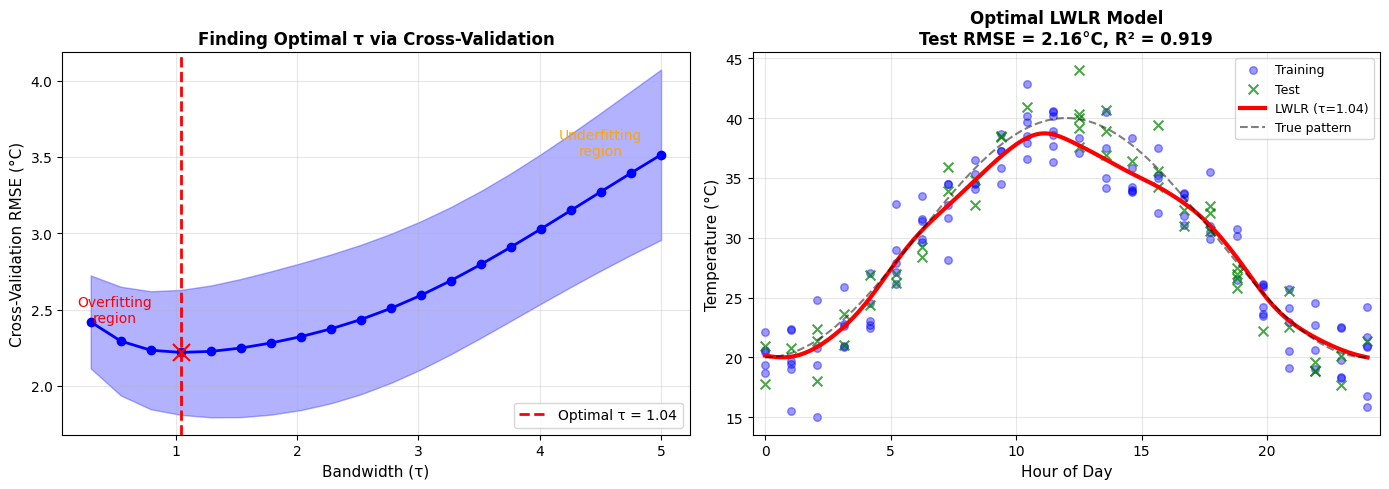

🎯 Final Model Performance (Optimal τ):
   Test RMSE: 2.163°C
   Test R²:   0.9191

   Compare to Linear Regression:
   LR Test RMSE: 7.623°C
   LR Test R²:   -0.0042

   🚀 LWLR reduces error by 71.6%!


In [9]:
# ============================================================
# VISUALIZE CROSS-VALIDATION RESULTS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: CV Error vs Tau
ax1 = axes[0]
ax1.plot(cv_results['tau'], cv_results['mean_rmse'], 'b-', linewidth=2, marker='o', markersize=6)
ax1.fill_between(cv_results['tau'], 
                  cv_results['mean_rmse'] - cv_results['std_rmse'],
                  cv_results['mean_rmse'] + cv_results['std_rmse'],
                  alpha=0.3, color='blue')
ax1.axvline(x=best_tau, color='red', linestyle='--', linewidth=2, label=f'Optimal τ = {best_tau:.2f}')
ax1.scatter([best_tau], [best_rmse], color='red', s=150, zorder=5, marker='x')

ax1.set_xlabel('Bandwidth (τ)', fontsize=11)
ax1.set_ylabel('Cross-Validation RMSE (°C)', fontsize=11)
ax1.set_title('Finding Optimal τ via Cross-Validation', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Add annotations
ax1.annotate('Overfitting\nregion', xy=(0.5, cv_results['mean_rmse'].iloc[0]), 
             fontsize=10, ha='center', color='red')
ax1.annotate('Underfitting\nregion', xy=(4.5, cv_results['mean_rmse'].iloc[-1]), 
             fontsize=10, ha='center', color='orange')

# Plot 2: Final model with optimal tau
ax2 = axes[1]

# Fit with optimal tau
optimal_model = LWLR(tau=best_tau)
y_smooth_optimal = optimal_model.predict(X_smooth, X_train, y_train)
y_test_pred_optimal = optimal_model.predict(X_test, X_train, y_train)

final_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_optimal))
final_r2 = r2_score(y_test, y_test_pred_optimal)

ax2.scatter(X_train, y_train, alpha=0.4, c='blue', s=30, label='Training')
ax2.scatter(X_test, y_test, alpha=0.7, c='green', s=50, marker='x', label='Test')
ax2.plot(X_smooth, y_smooth_optimal, 'r-', linewidth=3, label=f'LWLR (τ={best_tau:.2f})')
ax2.plot(X_smooth, y_true_pattern, 'k--', linewidth=1.5, alpha=0.5, label='True pattern')

ax2.set_xlabel('Hour of Day', fontsize=11)
ax2.set_ylabel('Temperature (°C)', fontsize=11)
ax2.set_title(f'Optimal LWLR Model\nTest RMSE = {final_rmse:.2f}°C, R² = {final_r2:.3f}', 
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-0.5, 24.5)

plt.tight_layout()
plt.show()

print("🎯 Final Model Performance (Optimal τ):")
print(f"   Test RMSE: {final_rmse:.3f}°C")
print(f"   Test R²:   {final_r2:.4f}")
print()
print("   Compare to Linear Regression:")
print(f"   LR Test RMSE: {metrics_lr['RMSE']:.3f}°C")
print(f"   LR Test R²:   {metrics_lr['R²']:.4f}")
print()
print(f"   🚀 LWLR reduces error by {(metrics_lr['RMSE'] - final_rmse) / metrics_lr['RMSE'] * 100:.1f}%!")

## 🔬 Part 7: Understanding LWLR Weights Visually

Let's **see** how LWLR assigns weights when predicting at different times of day.

When predicting temperature at:
- **Hour 6** (morning): Points near hour 6 get high weight
- **Hour 14** (afternoon): Points near hour 14 get high weight
- **Hour 20** (evening): Points near hour 20 get high weight

This is the LOCAL in Locally Weighted!

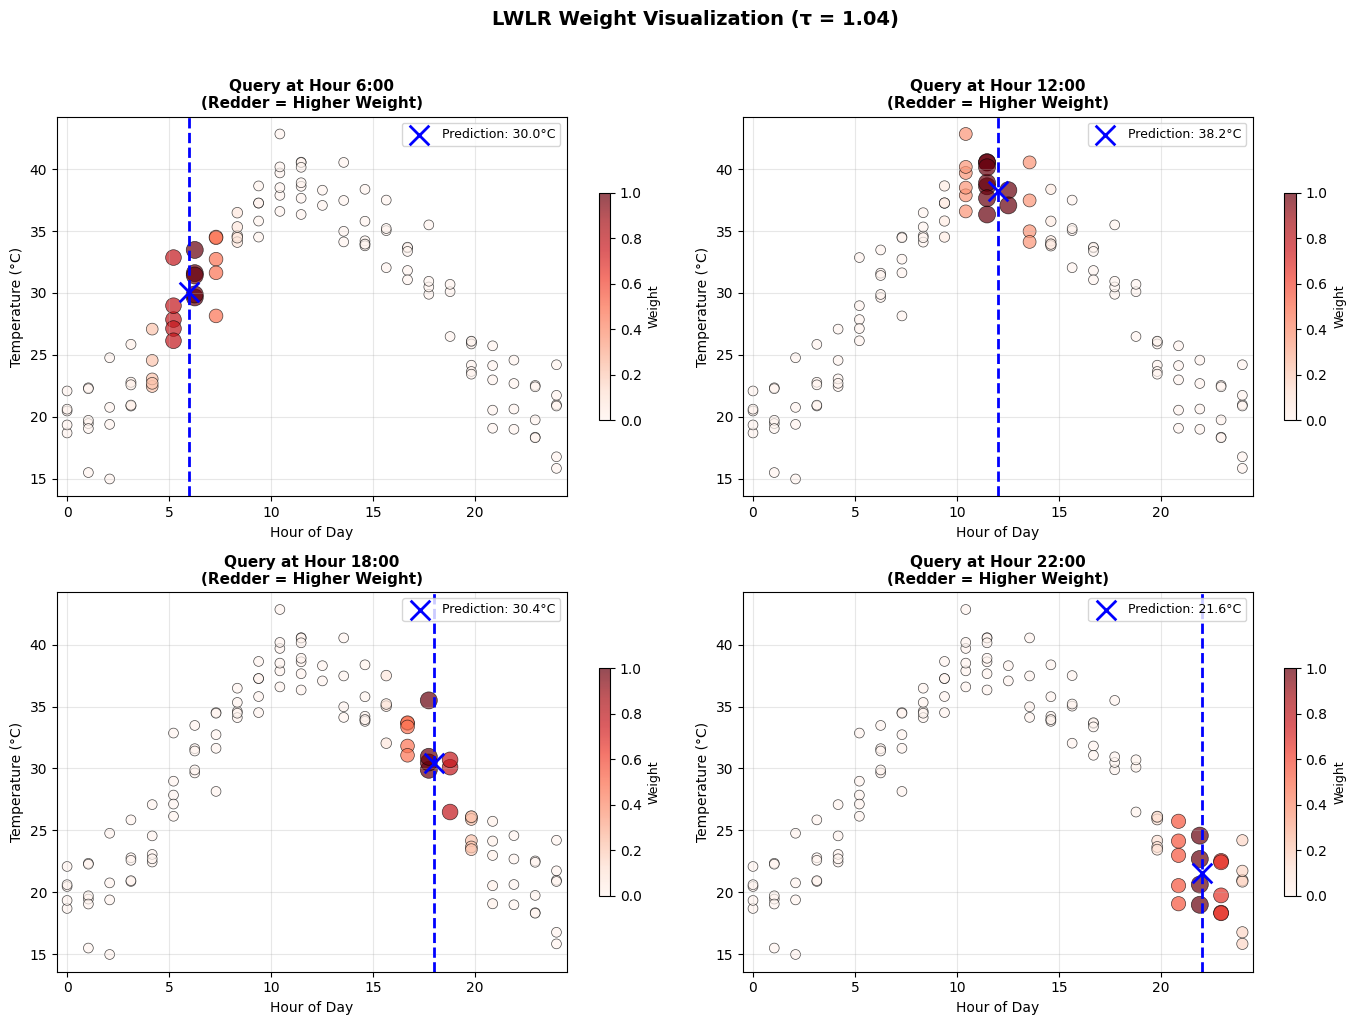

🔍 How to Read These Plots:
   • Blue dashed line: The hour we're predicting for
   • Larger/Redder points: Higher weight in regression
   • Blue star: Our prediction at that hour

💡 Notice: Only NEARBY points (in time) have high weight!
   This is why LWLR can capture local patterns.


In [11]:
# ============================================================
# VISUALIZE LWLR WEIGHTS FOR DIFFERENT QUERY POINTS
# ============================================================

def gaussian_weight(x_query, X, tau):
    """Compute Gaussian weights"""
    return np.exp(-(X - x_query)**2 / (2 * tau**2))

# Query points to visualize
query_hours = [6, 12, 18, 22]
tau = best_tau

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, q_hour in enumerate(query_hours):
    ax = axes[idx]
    
    # Compute weights for all training points
    weights = gaussian_weight(q_hour, X_train, tau)
    
    # Normalize for visualization
    weights_norm = weights / weights.max()
    
    # Create color based on weight
    colors = plt.cm.Reds(weights_norm)
    
    # Plot training points with color based on weight
    scatter = ax.scatter(X_train, y_train, c=weights_norm, cmap='Reds', 
                         s=50 + 100*weights_norm, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Mark the query point
    ax.axvline(x=q_hour, color='blue', linestyle='--', linewidth=2)
    
    # Make prediction
    model = LWLR(tau=tau)
    pred = model.predict_single(q_hour, X_train.reshape(-1, 1), y_train)
    ax.scatter([q_hour], [pred], color='blue', s=200, marker='x', zorder=5, 
               edgecolors='white', linewidth=2, label=f'Prediction: {pred:.1f}°C')
    
    ax.set_xlabel('Hour of Day', fontsize=10)
    ax.set_ylabel('Temperature (°C)', fontsize=10)
    ax.set_title(f'Query at Hour {q_hour}:00\n(Redder = Higher Weight)', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.5, 24.5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
    cbar.set_label('Weight', fontsize=9)

plt.suptitle(f'LWLR Weight Visualization (τ = {tau:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("🔍 How to Read These Plots:")
print("   • Blue dashed line: The hour we're predicting for")
print("   • Larger/Redder points: Higher weight in regression")
print("   • Blue star: Our prediction at that hour")
print()
print("💡 Notice: Only NEARBY points (in time) have high weight!")
print("   This is why LWLR can capture local patterns.")